### Inspiration from following sources: 
### ------------------------------------
### EDA: 
#####   https://www.analyticsvidhya.com/blog/2021/04/rapid-fire-eda-process-using-python-for-ml-implementation/
### ------------------------------------
### Datacamp Courses: 
#####                 Case Study: School Budgeting with Machine Learning in Python
#####                 Marketing Analytics: Predicting Customer Churn in Python
#####                 Machine Learning for Business
#####                 Model Validation in Python
### ------------------------------------
### Evaluation: 
##### https://machinelearningmastery.com/calculate-feature-importance-with-python/
##### https://towardsdatascience.com/evaluation-metrics-model-selection-in-linear-regression-73c7573208be
##### https://towardsdatascience.com/all-about-feature-scaling-bcc0ad75cb35
##### https://www.analyticsvidhya.com/blog/2021/05/know-the-best-evaluation-metrics-for-your-regression-model/
### ------------------------------------
### Kaggle:
##### https://www.kaggle.com/juliencs/a-study-on-regression-applied-to-the-ames-dataset

## Importing libraries and data

In [143]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_validate
from sklearn.metrics import  mean_squared_error, mean_absolute_percentage_error, r2_score
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.neighbors import KNeighborsRegressor

In [144]:
df = pd.read_csv('prediktiv_data.csv')

In [145]:
df.head()

,id,target,feature01,feature02,feature03,feature04,feature05,feature06,feature07,feature08,...,feature14,feature15,feature16,feature17,feature18,feature19,feature20,feature21,feature22,feature23
0,1,215000,2.0,528.0,0,1080.0,1656,7,1656,6,...,2,good,bad,3,1,5,2010,0,0,1960
1,2,105000,1.0,730.0,0,882.0,896,5,896,5,...,0,NaN,bad,2,1,6,2010,0,0,1961
2,3,172000,1.0,312.0,0,1329.0,1329,6,1329,6,...,0,NaN,good,3,1,6,2010,1,0,1958
3,4,244000,2.0,522.0,0,2110.0,2110,8,2110,7,...,2,bad,amazing,3,1,4,2010,1,0,1968
4,5,189900,2.0,482.0,0,928.0,928,6,1629,5,...,1,bad,bad,3,1,3,2010,1,701,1998


##### I will see how many rows and columns there are in the dataframe, I will save this into a variable to be able to compare with later if I drop data, to see how much data I have lost.

In [146]:
original_shape = df.shape
original_shape

(2930, 26)

## Preprocessing

In [147]:
df.id.nunique()

2930

##### Since the column 'id' have unique values for each row and does not have any other impact on the prediction/analysis, I will set this column as the index. 

In [148]:
df.set_index('id', inplace=True)

##### To be able to make a prediction I have to handle missing values. 
##### I will sum up all NAs to find out how many NAs there are in each column.

In [149]:
df.isna().sum()

target            0
feature01         1
feature02         1
feature03         0
feature04         1
feature05         0
feature06         0
feature07         0
feature08         0
feature09         0
feature10         0
feature10.1       0
feature11      2732
feature12      2358
feature13         1
feature14         0
feature15      1422
feature16         0
feature17         0
feature18         0
feature19         0
feature20         0
feature21         0
feature22         0
feature23         0
dtype: int64

##### Since there are too many NA-values in relation to the sum of rows in column 'feature11', 'feature12' and 'feature15' and we still have many features to work with, I have decided to delete these columns.

In [150]:
df.drop(['feature11', 'feature12', 'feature15'], axis=1, inplace=True)

##### Now I have four missing values left, for feature01, feature02 and feature04 I will take the mean of each column and give this value to the NAs.
##### Since feature13 is of categorical data, I will use the mode instead, so this missing value will be set to the color that is most frequent in this column.

In [151]:
df['feature01'].fillna(df['feature01'].mean(), inplace=True)
df['feature02'].fillna(df['feature02'].mean(), inplace=True)
df['feature04'].fillna(df['feature04'].mean(), inplace=True)
df['feature13'].fillna(df['feature13'].value_counts().index[0], inplace=True)

In [152]:
df.isna().sum()

target         0
feature01      0
feature02      0
feature03      0
feature04      0
feature05      0
feature06      0
feature07      0
feature08      0
feature09      0
feature10      0
feature10.1    0
feature13      0
feature14      0
feature16      0
feature17      0
feature18      0
feature19      0
feature20      0
feature21      0
feature22      0
feature23      0
dtype: int64

In [153]:
df.dtypes

target           int64
feature01      float64
feature02      float64
feature03        int64
feature04      float64
feature05        int64
feature06        int64
feature07        int64
feature08        int64
feature09        int64
feature10        int64
feature10.1      int64
feature13       object
feature14        int64
feature16       object
feature17        int64
feature18        int64
feature19        int64
feature20        int64
feature21        int64
feature22        int64
feature23        int64
dtype: object

##### Features 13 and 16 are of categorical data, all other features are of numerical data, to be able to make a prediction including these features, I have decided to split these columns into numerical value/columns instead.

In [154]:
df = pd.get_dummies(df, columns=['feature13', 'feature16'])

##### Feature01, 02 and 04 is having a datatype of 'float', I will turn these ones into int so all columns will be the same.

In [155]:
df = df.astype(np.int64)

##### Renaming the columns

In [156]:
df.rename({'feature10.1': 'feature11',
           'feature13_blue': 'blue',
           'feature13_green': 'green',
           'feature13_pink': 'pink',
           'feature13_red': 'red',
           'feature13_yellow': 'yellow',
           'feature16_amazing': 'amazing',
           'feature16_bad': 'bad',
           'feature16_good': 'good',
           'feature16_horrible': 'horrible',
           'feature16_okay': 'okay'
           }, axis=1, inplace=True)

##### Creating a new dataframe with all features for a first predicition, and another dataframe which I will use to process data/features after the first prediction.

In [157]:
df_AllFeatures = df
df_optimized = df

## Training Models

In [158]:
# Creating target variable, features and scaling.
target_name = 'target'
robust_scaler = RobustScaler()
X = df_AllFeatures.drop('target', axis=1)
X = robust_scaler.fit_transform(X)
y = df_AllFeatures[target_name]

##### NULL Model

In [159]:
y_pred_null = y.mean()
null_test_rmse_AllFeatures = -1*mean_squared_error(y_pred=np.repeat(y_pred_null, y.size), y_true=y, squared=False)
null_test_mape_AllFeatures = -1*mean_absolute_percentage_error(y_pred=np.repeat(y_pred_null, y.size), y_true=y)

### Models and K-fold cross validation

In [160]:
rf = RandomForestRegressor(n_estimators=50, max_depth=15, random_state=2, n_jobs=-1)
rf_test_rmse_AllFeatures = cross_validate(estimator=rf,X=X,y=y,
                                    scoring='neg_root_mean_squared_error',
                                    cv=10, n_jobs=-1)['test_score']
rf_test_mape_AllFeatures = cross_validate(estimator=rf,X=X,y=y,
                                    scoring='neg_mean_absolute_percentage_error', 
                                    cv=10, n_jobs=-1)['test_score']
rf_test_r2_AllFeatures = cross_validate(estimator=rf,X=X,y=y,
                                    scoring='r2', 
                                    cv=10, n_jobs=-1)['test_score']


knn = KNeighborsRegressor(n_neighbors=20, weights='distance', metric='euclidean', n_jobs=-1)
knn_test_rmse_AllFeatures = cross_validate(estimator=knn,X=X,y=y,
                                    scoring='neg_root_mean_squared_error', 
                                    cv=10, n_jobs=-1)['test_score']
knn_test_mape_AllFeatures = cross_validate(estimator=knn,X=X,y=y,
                                    scoring='neg_mean_absolute_percentage_error', 
                                    cv=10, n_jobs=-1)['test_score']
knn_test_r2_AllFeatures = cross_validate(estimator=knn,X=X,y=y,
                                    scoring='r2', 
                                    cv=10, n_jobs=-1)['test_score']                                    


boosting = AdaBoostRegressor(n_estimators=50, learning_rate=1.0, random_state=2)  
boosting_test_rmse_AllFeatures = cross_validate(estimator=boosting,X=X,y=y,
                                    scoring='neg_root_mean_squared_error', 
                                    cv=10, n_jobs=-1)['test_score']
boosting_test_mape_AllFeatures = cross_validate(estimator=boosting,X=X,y=y,
                                    scoring='neg_mean_absolute_percentage_error', 
                                    cv=10, n_jobs=-1)['test_score']
boosting_test_r2_AllFeatures = cross_validate(estimator=boosting,X=X,y=y,
                                    scoring='r2', 
                                    cv=10, n_jobs=-1)['test_score']

## First evaluation
##### I will use root-mean-square error, Mean absolute percentage error and R-squared to evalute my models. I think using MAPE which is scale-independent and R2 is a good way to measure the accuracy and to compare the different models.

In [161]:
r2_models_AllFeatures =  pd.DataFrame({'KNN All Features':knn_test_r2_AllFeatures,
                           'RandomForest All Features': rf_test_r2_AllFeatures,
                           'Boosting All Features':boosting_test_r2_AllFeatures,})
r2_models_AllFeatures

,KNN All Features,RandomForest All Features,Boosting All Features
0,0.869062,0.884119,0.808283
1,0.864016,0.892076,0.843690
2,0.818006,0.857197,0.657705
3,0.882616,0.901715,0.837419
4,0.818857,0.776063,0.671130
5,0.820076,0.871088,0.773677
6,0.726790,0.853883,0.793486
7,0.718868,0.745010,0.732367
8,0.887787,0.923655,0.857789
9,0.784105,0.809153,0.689474


In [162]:
mape_models_AllFeatures = -1*pd.DataFrame({'KNN All Features':knn_test_mape_AllFeatures,
                           'RandomForest All Features': rf_test_mape_AllFeatures,
                           'Boosting All Features':boosting_test_mape_AllFeatures,
                           'NULL All Features': null_test_mape_AllFeatures})
mape_models_AllFeatures

,KNN All Features,RandomForest All Features,Boosting All Features,NULL All Features
0,0.135028,0.120822,0.193446,0.375508
1,0.117895,0.105091,0.163252,0.375508
2,0.125370,0.111705,0.209209,0.375508
3,0.102290,0.087208,0.156540,0.375508
4,0.117261,0.109165,0.175983,0.375508
5,0.134678,0.109696,0.193682,0.375508
6,0.108143,0.098420,0.154358,0.375508
7,0.128198,0.119590,0.155742,0.375508
8,0.097218,0.083161,0.135159,0.375508
9,0.142743,0.124309,0.202686,0.375508


In [163]:
rmse_models_AllFeatures = -1*pd.DataFrame({'KNN All Features':knn_test_rmse_AllFeatures,
                           'RandomForest All Features': rf_test_rmse_AllFeatures,
                           'Boosting All Features':boosting_test_rmse_AllFeatures,
                           'NULL All Features':null_test_rmse_AllFeatures})
rmse_models_AllFeatures

,KNN All Features,RandomForest All Features,Boosting All Features,NULL All Features
0,27010.587093,25410.209163,32683.757220,79873.058652
1,34233.396911,30497.545640,36702.815209,79873.058652
2,22551.072847,19975.950922,30927.095294,79873.058652
3,29234.963365,26751.141783,34406.013395,79873.058652
4,24114.944864,26812.550900,32492.869133,79873.058652
5,37099.626517,31403.068065,41609.124560,79873.058652
6,43315.092144,31676.848512,37658.755439,79873.058652
7,43271.164855,41210.156583,42219.493301,79873.058652
8,28179.132081,23243.269506,31722.864553,79873.058652
9,29318.775218,27565.539606,35161.940147,79873.058652


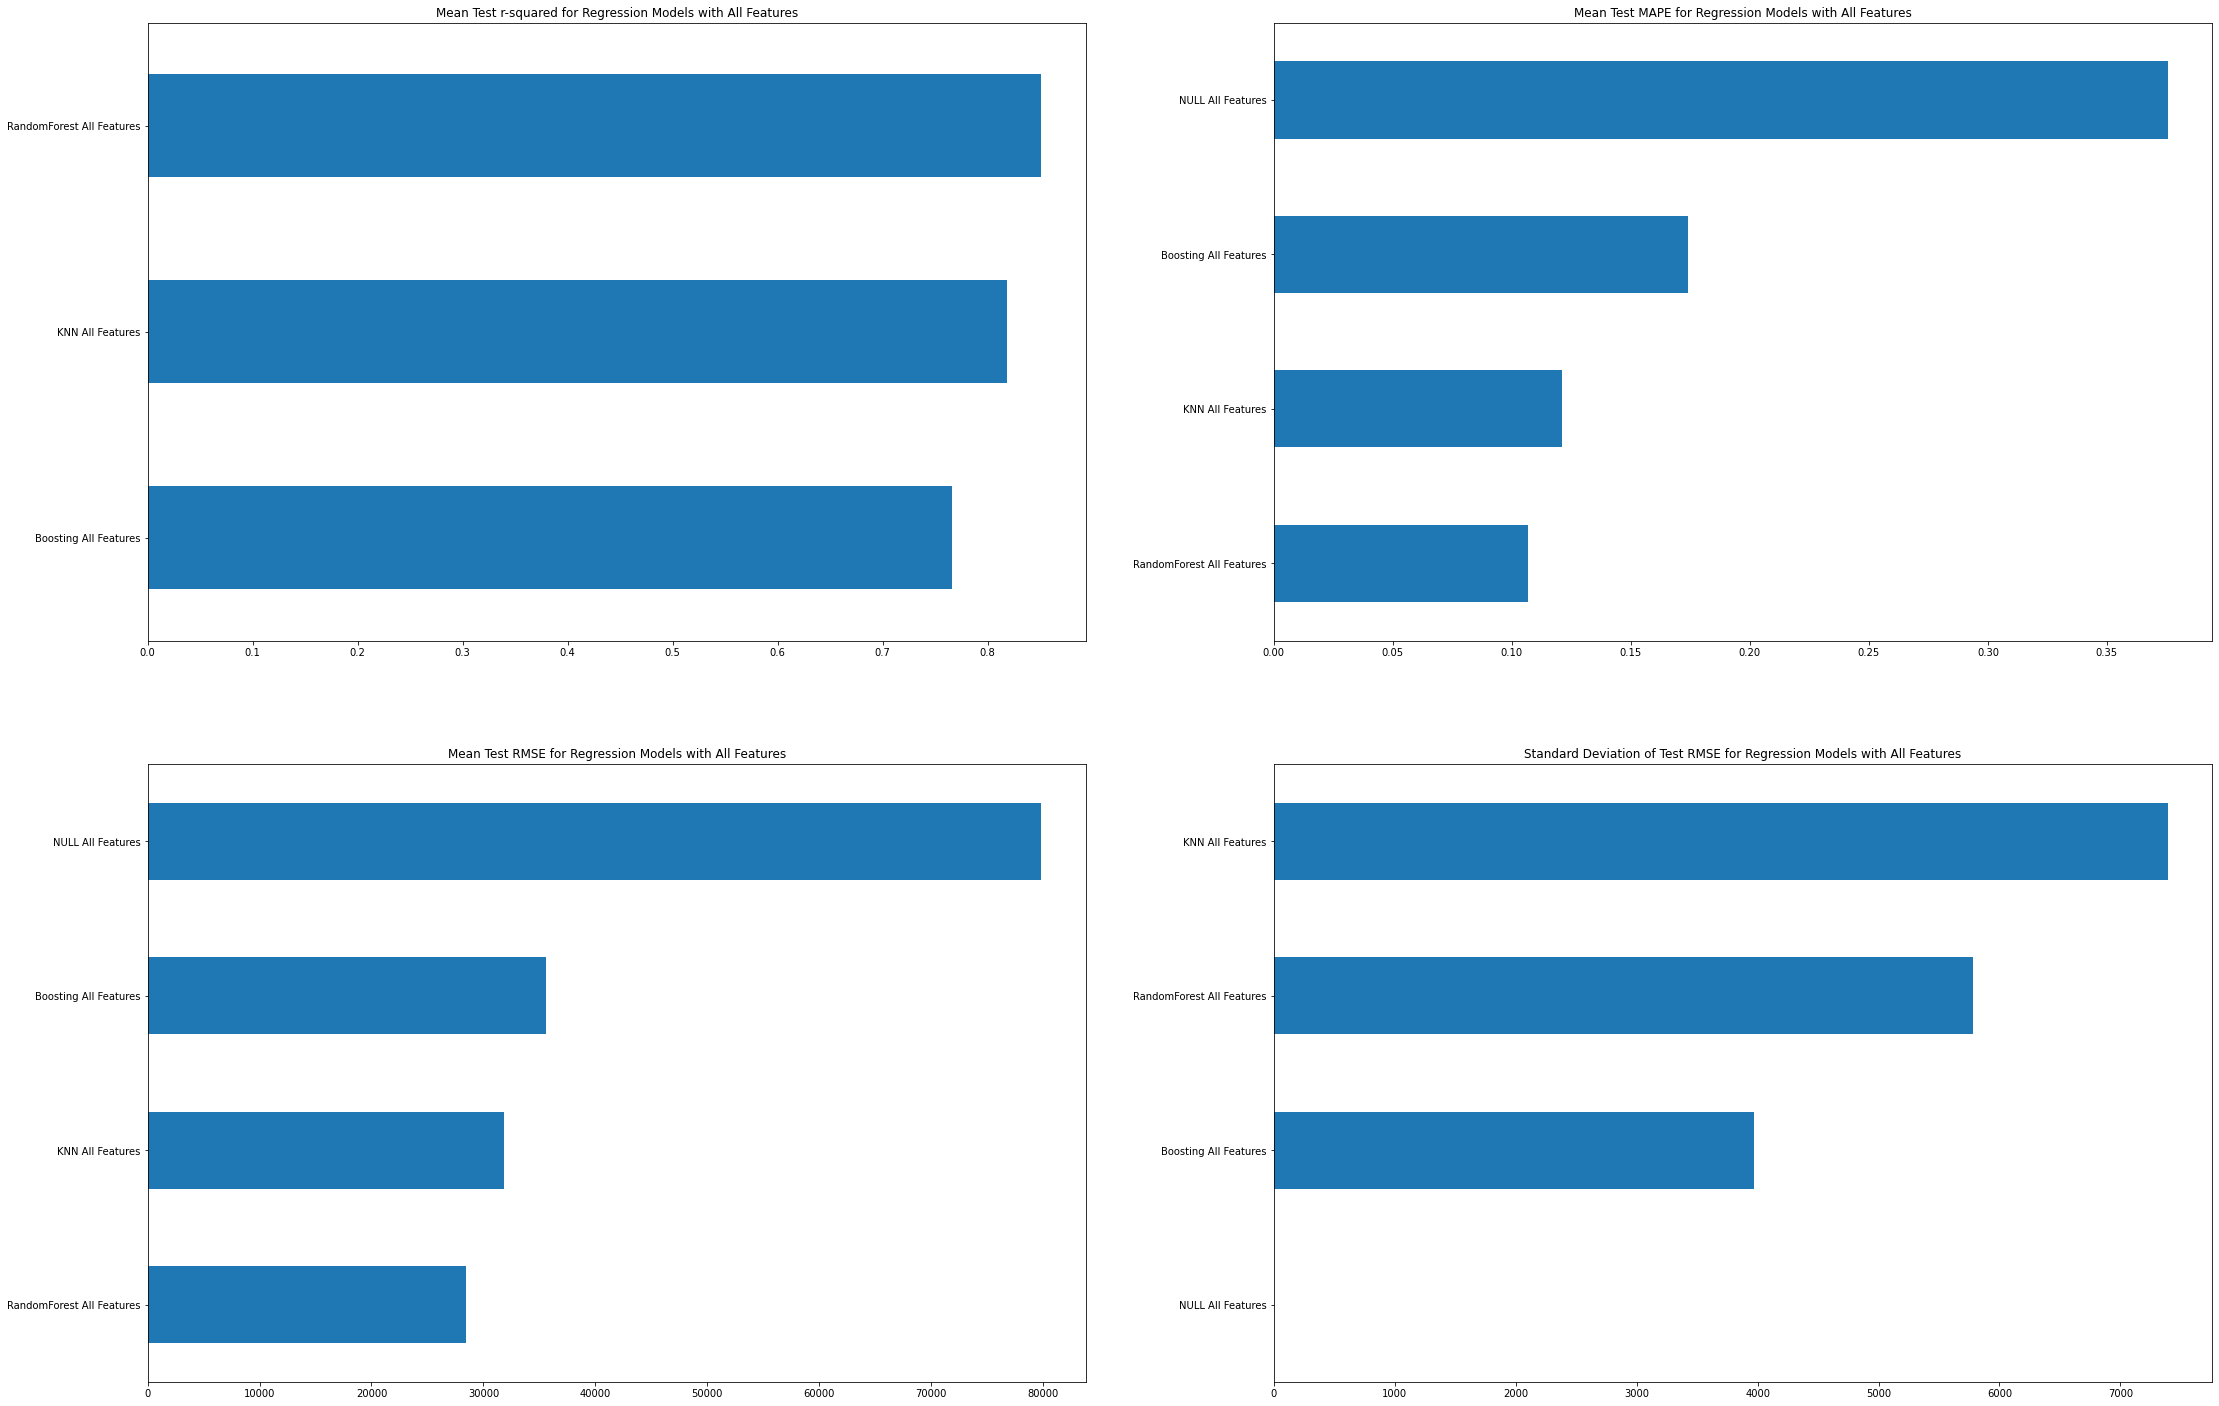

In [164]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(37,25))

r2_models_AllFeatures.mean().sort_values().plot(kind='barh', ax=ax1)
ax1.set_title('Mean Test r-squared for Regression Models with All Features')
mape_models_AllFeatures.mean().sort_values().plot(kind='barh', ax=ax2)
ax2.set_title('Mean Test MAPE for Regression Models with All Features')
rmse_models_AllFeatures.mean().sort_values().plot(kind='barh', ax=ax3)
ax3.set_title('Mean Test RMSE for Regression Models with All Features')
rmse_models_AllFeatures.std().sort_values().plot(kind='barh', ax=ax4)
ax4.set_title('Standard Deviation of Test RMSE for Regression Models with All Features');

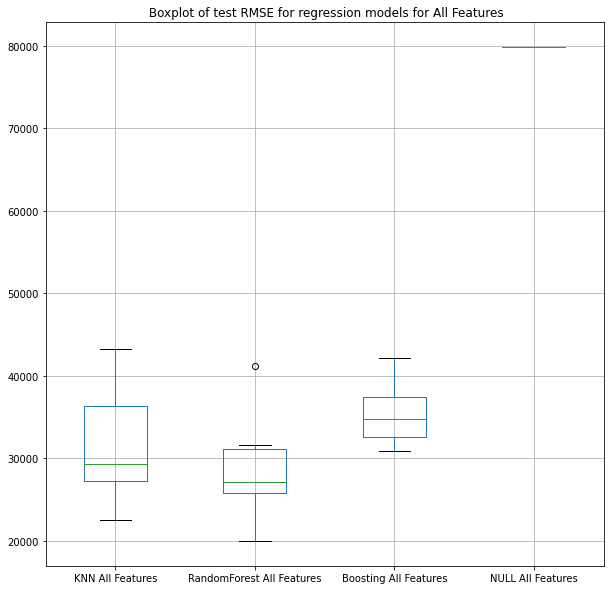

In [165]:
fig, ax = plt.subplots(figsize=(10,10))
rmse_models_AllFeatures.boxplot(ax=ax)
ax.set_title(' Boxplot of test RMSE for regression models for All Features');

##### It seems like the RandomForest is performing best of the models, I will try to optimize all models and then compare them to each other to see if I get the error metrics and MAPE down and the R2 values up.

## Optimization, deleting outliers and feature selection.
##### I will take on a manual approach of feature selection, delete outliers and choose features by looking at different kinds of plots. I will start to plot the target variable to see the distribution and outliers of the data.

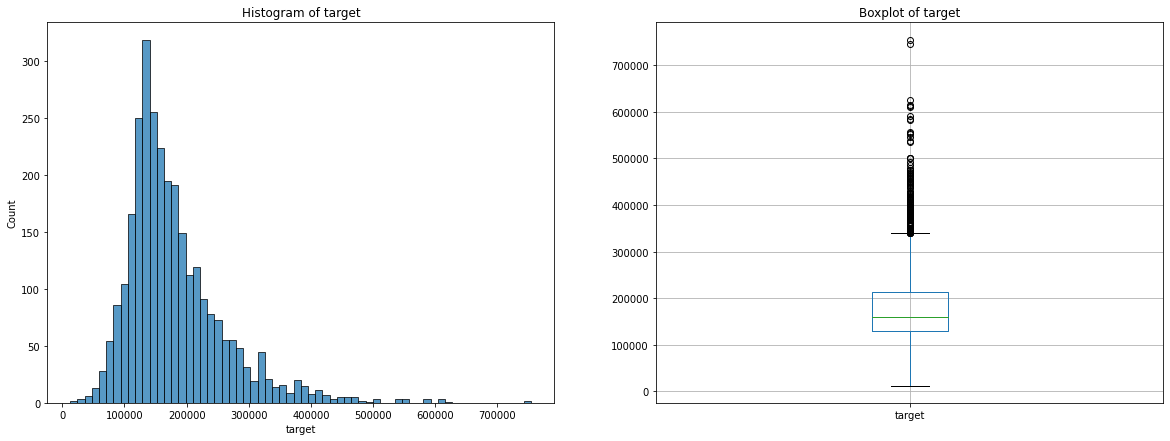

In [166]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,7))

sns.histplot(df['target'], ax=ax1)
ax1.set_title('Histogram of target')
df.boxplot(column='target', ax=ax2)
ax2.set_title('Boxplot of target');

##### The data is right-skewed, it seems like there is some outliers in the higher range of the data that I will have to take care of.

##### I will drop the values above 400,000 and the few under 15,000, because it is not that many values compared to the whole dataset and I think it will be a more accurate prediciton without these outliers.

In [167]:
df_optimized = df.drop(df[(df['target'] > 400000)].index)
df_optimized = df_optimized.drop(df_optimized[(df_optimized['target'] < 15000)].index)

##### I will check the difference between rows and columns from before and after deleting values.

In [168]:
current_shape = df_optimized.shape
print(f'Original rows and columns: {original_shape}')
print(f'Current rows and columns: {current_shape}')

Original rows and columns: (2930, 26)
Current rows and columns: (2864, 30)


##### Checking the correlation between the target and the other features.

In [169]:
print('Correlation between the target compared to the other features')
corr = df_optimized.corr()
corr.sort_values(['target'], ascending = False, inplace = True)
print(corr.target)

Correlation between the target compared to the other features
target       1.000000
feature08    0.797857
feature07    0.665623
feature01    0.651119
feature02    0.631927
feature10    0.589360
feature04    0.582704
feature05    0.569521
feature23    0.559460
feature11    0.553628
feature14    0.468555
feature06    0.443687
good         0.420670
amazing      0.409596
feature21    0.269310
red          0.260803
feature22    0.253994
feature17    0.139969
feature19    0.053415
feature03    0.035688
horrible    -0.018892
feature20   -0.019213
pink        -0.030345
yellow      -0.067375
feature09   -0.090817
feature18   -0.125930
green       -0.138338
okay        -0.159415
blue        -0.205786
bad         -0.547432
Name: target, dtype: float64


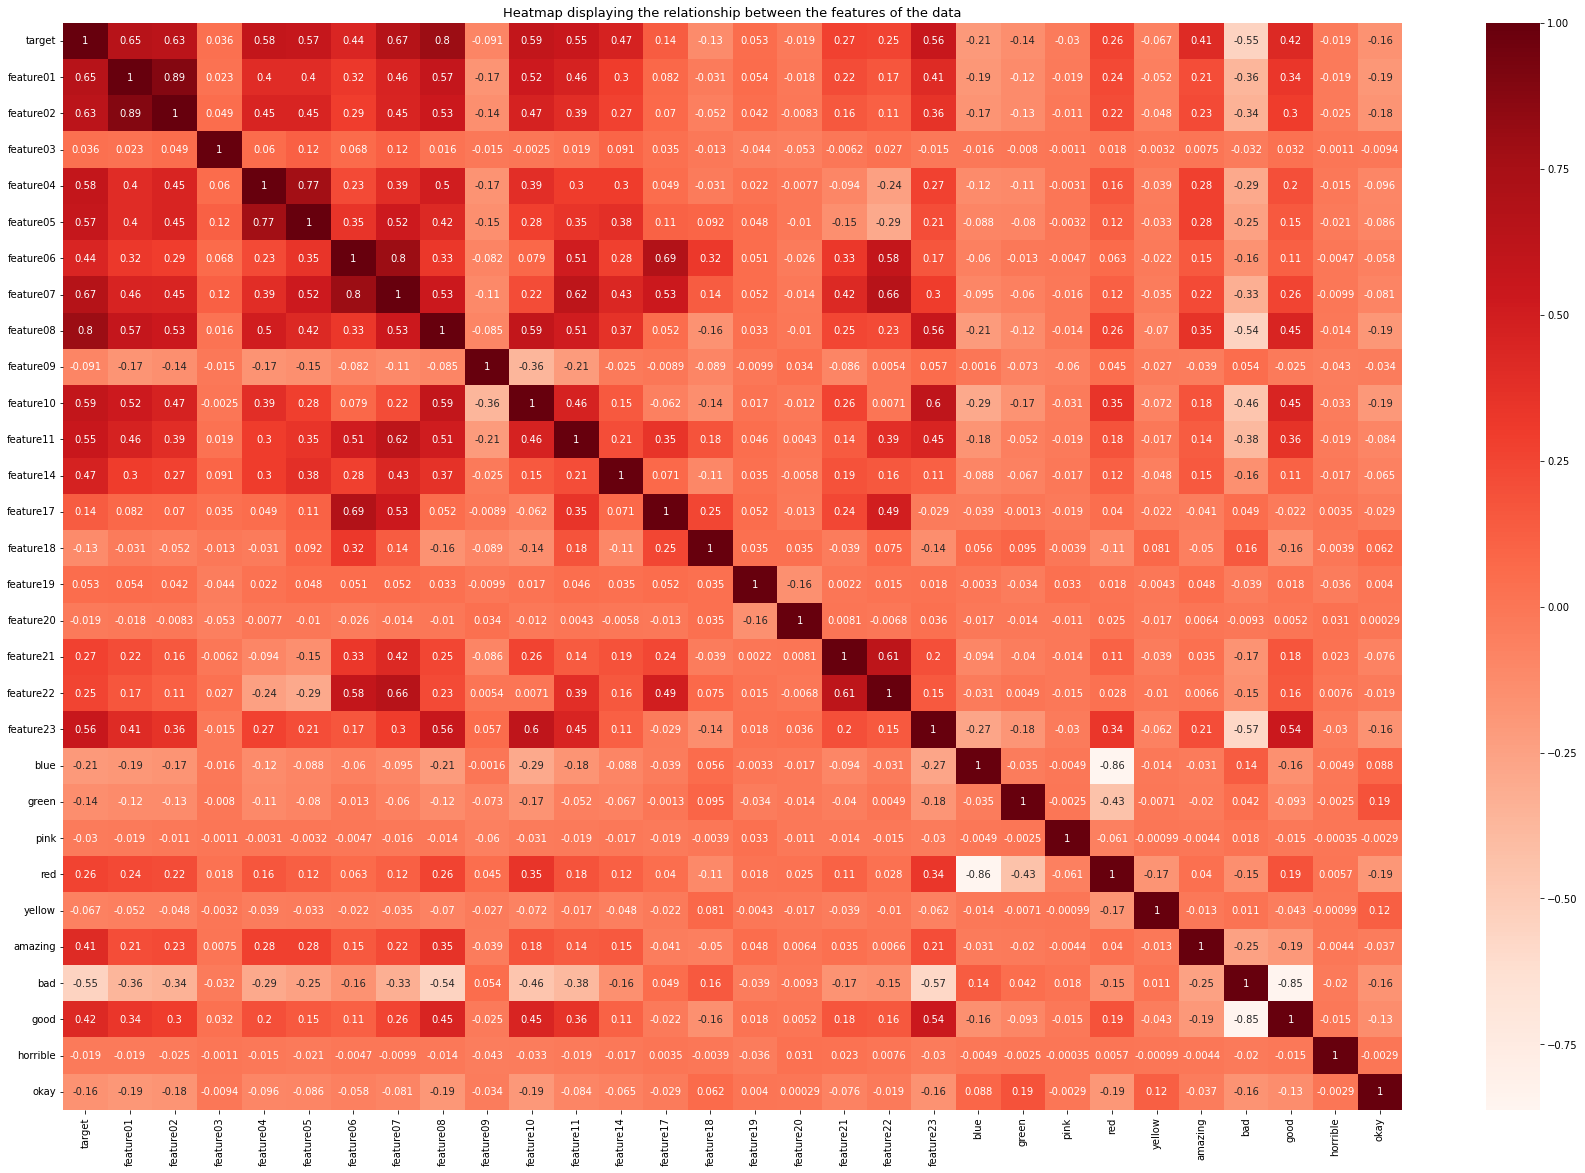

In [170]:
plt.figure(figsize=(30,20))
sns.heatmap(df_optimized[:].corr(),cmap=plt.cm.Reds,annot=True)
plt.title('Heatmap displaying the relationship between the features of the data',
         fontsize=13)
plt.show()

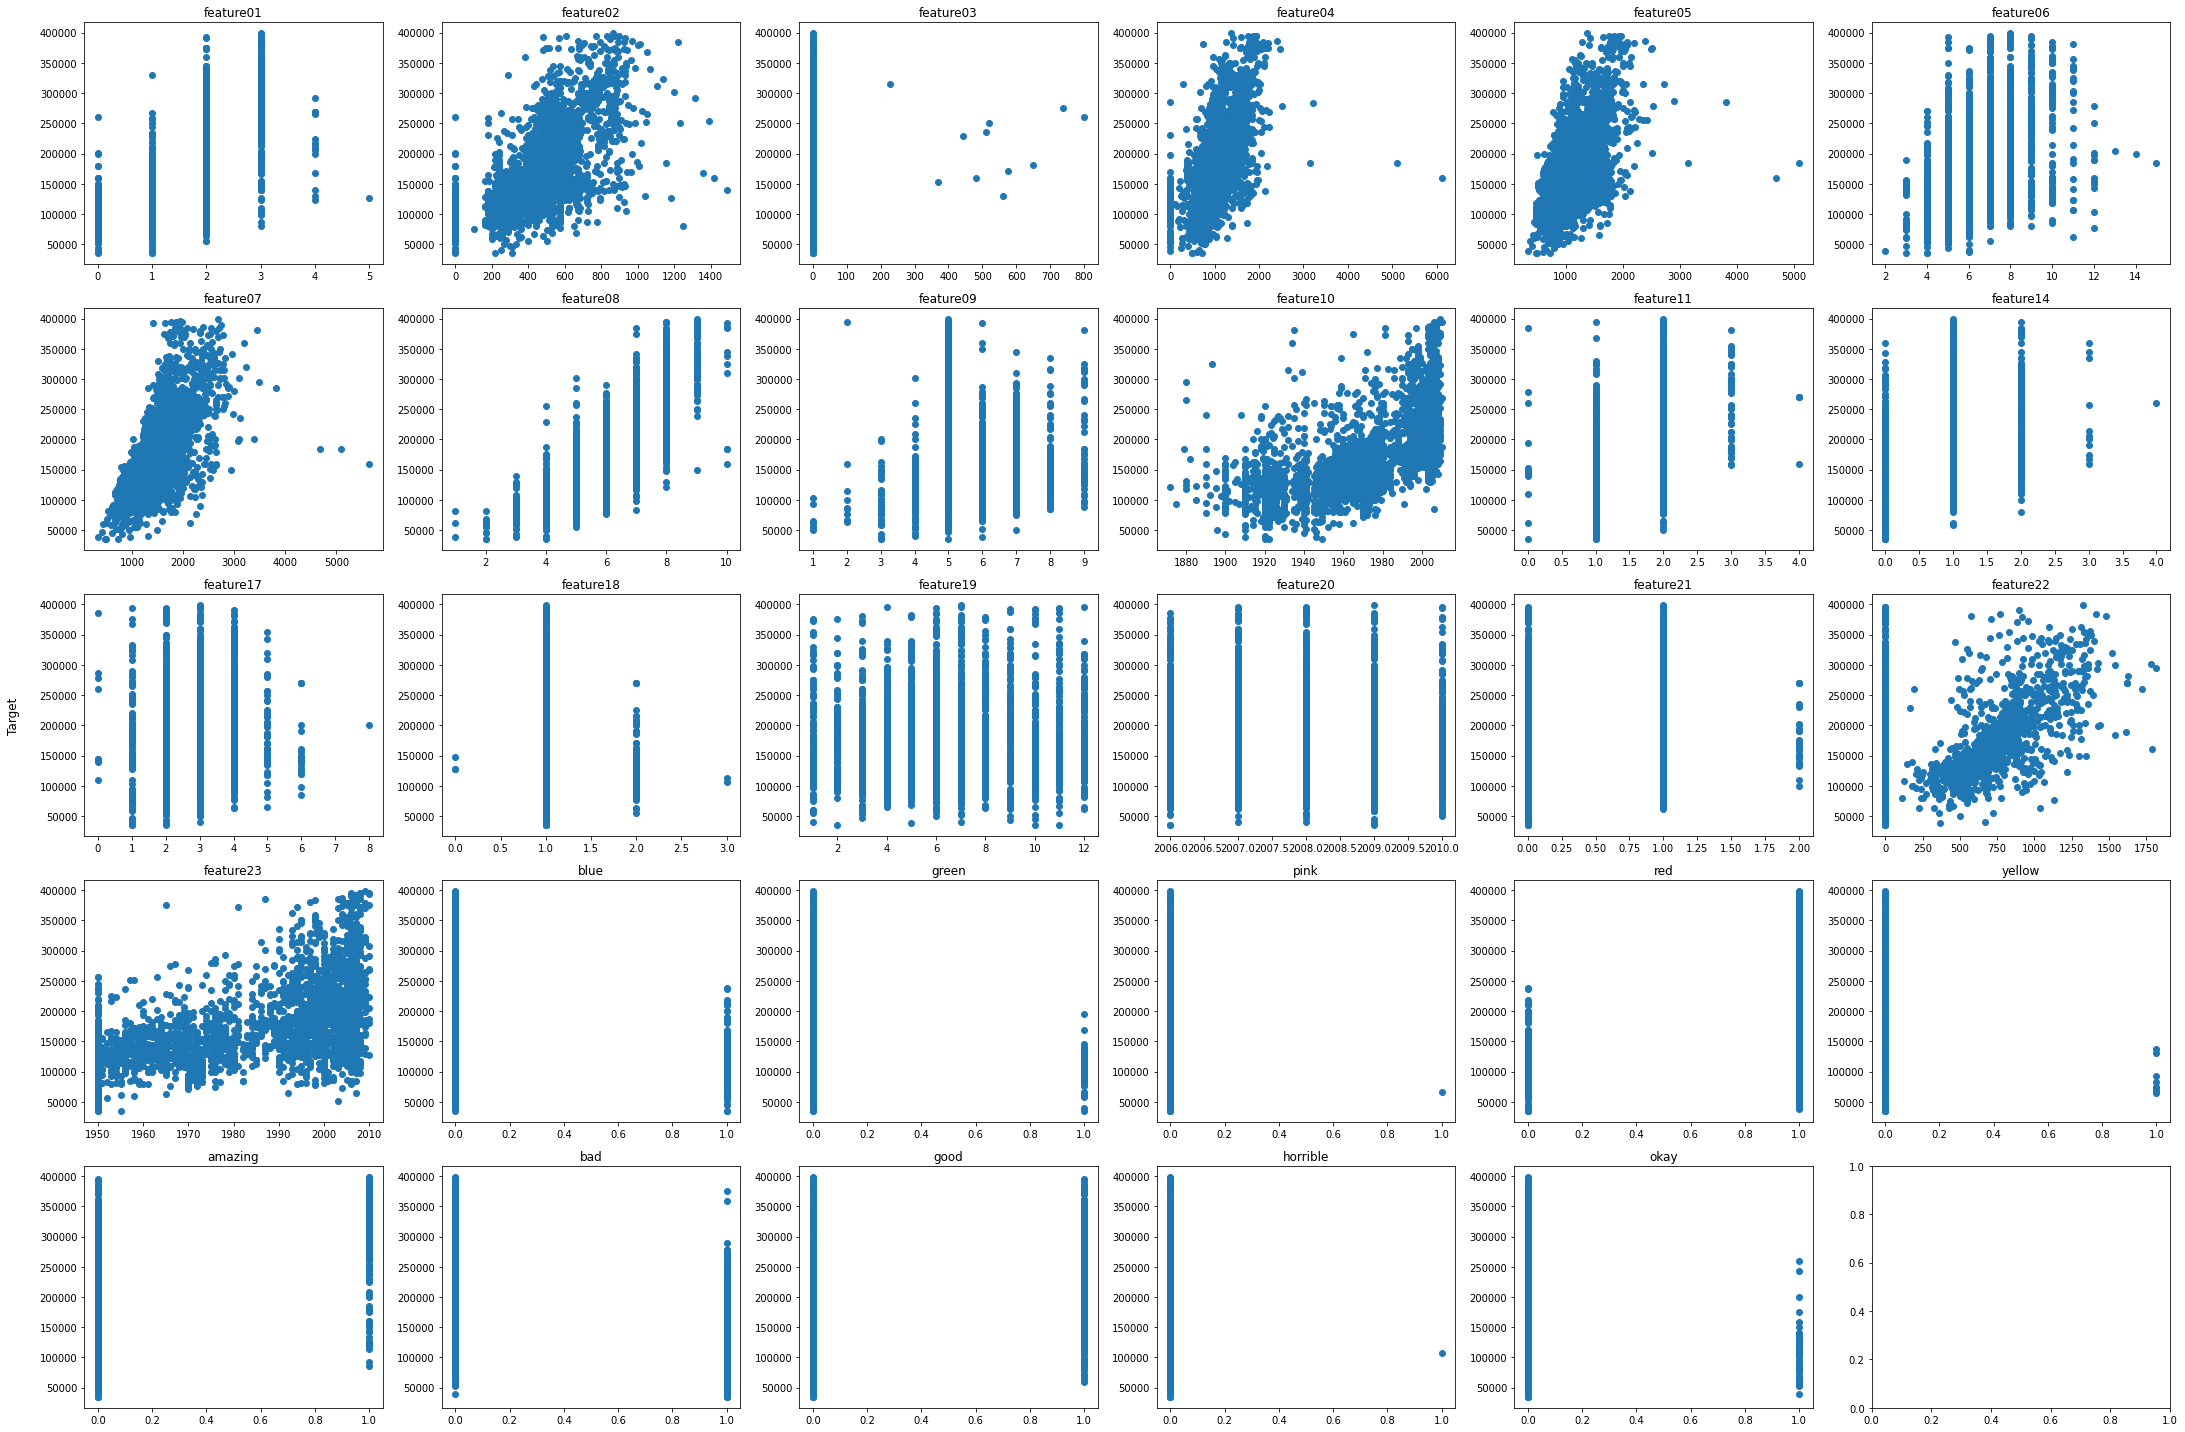

In [171]:
f, axarr = plt.subplots(5, 6, figsize=(30, 20))
target = df_optimized.target.values
axarr[0, 0].scatter(df_optimized.feature01.values, target)
axarr[0, 0].set_title('feature01')
axarr[0, 1].scatter(df_optimized.feature02.values, target)
axarr[0, 1].set_title('feature02')
axarr[0, 2].scatter(df_optimized.feature03.values, target)
axarr[0, 2].set_title('feature03')
axarr[0, 3].scatter(df_optimized.feature04.values, target)
axarr[0, 3].set_title('feature04')
axarr[0, 4].scatter(df_optimized.feature05.values, target)
axarr[0, 4].set_title('feature05')
axarr[0, 5].scatter(df_optimized.feature06.values, target)
axarr[0, 5].set_title('feature06')
axarr[1, 0].scatter(df_optimized.feature07.values, target)
axarr[1, 0].set_title('feature07')
axarr[1, 1].scatter(df_optimized.feature08.values, target)
axarr[1, 1].set_title('feature08')
axarr[1, 2].scatter(df_optimized.feature09.values, target)
axarr[1, 2].set_title('feature09')
axarr[1, 3].scatter(df_optimized.feature10.values, target)
axarr[1, 3].set_title('feature10')
axarr[1, 4].scatter(df_optimized.feature11.values, target)
axarr[1, 4].set_title('feature11')
axarr[1, 5].scatter(df_optimized.feature14.values, target)
axarr[1, 5].set_title('feature14')
axarr[2, 0].scatter(df_optimized.feature17.values, target)
axarr[2, 0].set_title('feature17')
axarr[2, 1].scatter(df_optimized.feature18.values, target)
axarr[2, 1].set_title('feature18')
axarr[2, 2].scatter(df_optimized.feature19.values, target)
axarr[2, 2].set_title('feature19')
axarr[2, 3].scatter(df_optimized.feature20.values, target)
axarr[2, 3].set_title('feature20')
axarr[2, 4].scatter(df_optimized.feature21.values, target)
axarr[2, 4].set_title('feature21')
axarr[2, 5].scatter(df_optimized.feature22.values, target)
axarr[2, 5].set_title('feature22')
axarr[3, 0].scatter(df_optimized.feature23.values, target)
axarr[3, 0].set_title('feature23')
axarr[3, 1].scatter(df_optimized.blue.values, target)
axarr[3, 1].set_title('blue')
axarr[3, 2].scatter(df_optimized.green.values, target)
axarr[3, 2].set_title('green')
axarr[3, 3].scatter(df_optimized.pink.values, target)
axarr[3, 3].set_title('pink')
axarr[3, 4].scatter(df_optimized.red.values, target)
axarr[3, 4].set_title('red')
axarr[3, 5].scatter(df_optimized.yellow.values, target)
axarr[3, 5].set_title('yellow')
axarr[4, 0].scatter(df_optimized.amazing.values, target)
axarr[4, 0].set_title('amazing')
axarr[4, 1].scatter(df_optimized.bad.values, target)
axarr[4, 1].set_title('bad')
axarr[4, 2].scatter(df_optimized.good.values, target)
axarr[4, 2].set_title('good')
axarr[4, 3].scatter(df_optimized.horrible.values, target)
axarr[4, 3].set_title('horrible')
axarr[4, 4].scatter(df_optimized.okay.values, target)
axarr[4, 4].set_title('okay')
f.text(-0.01, 0.5, 'Target', va='center', rotation='vertical', fontsize = 12)
plt.tight_layout()
plt.show()

##### Feature 08, 07, 01 and 02 seems to be most correlated with the target.

### Checking the distribution of target and all features.

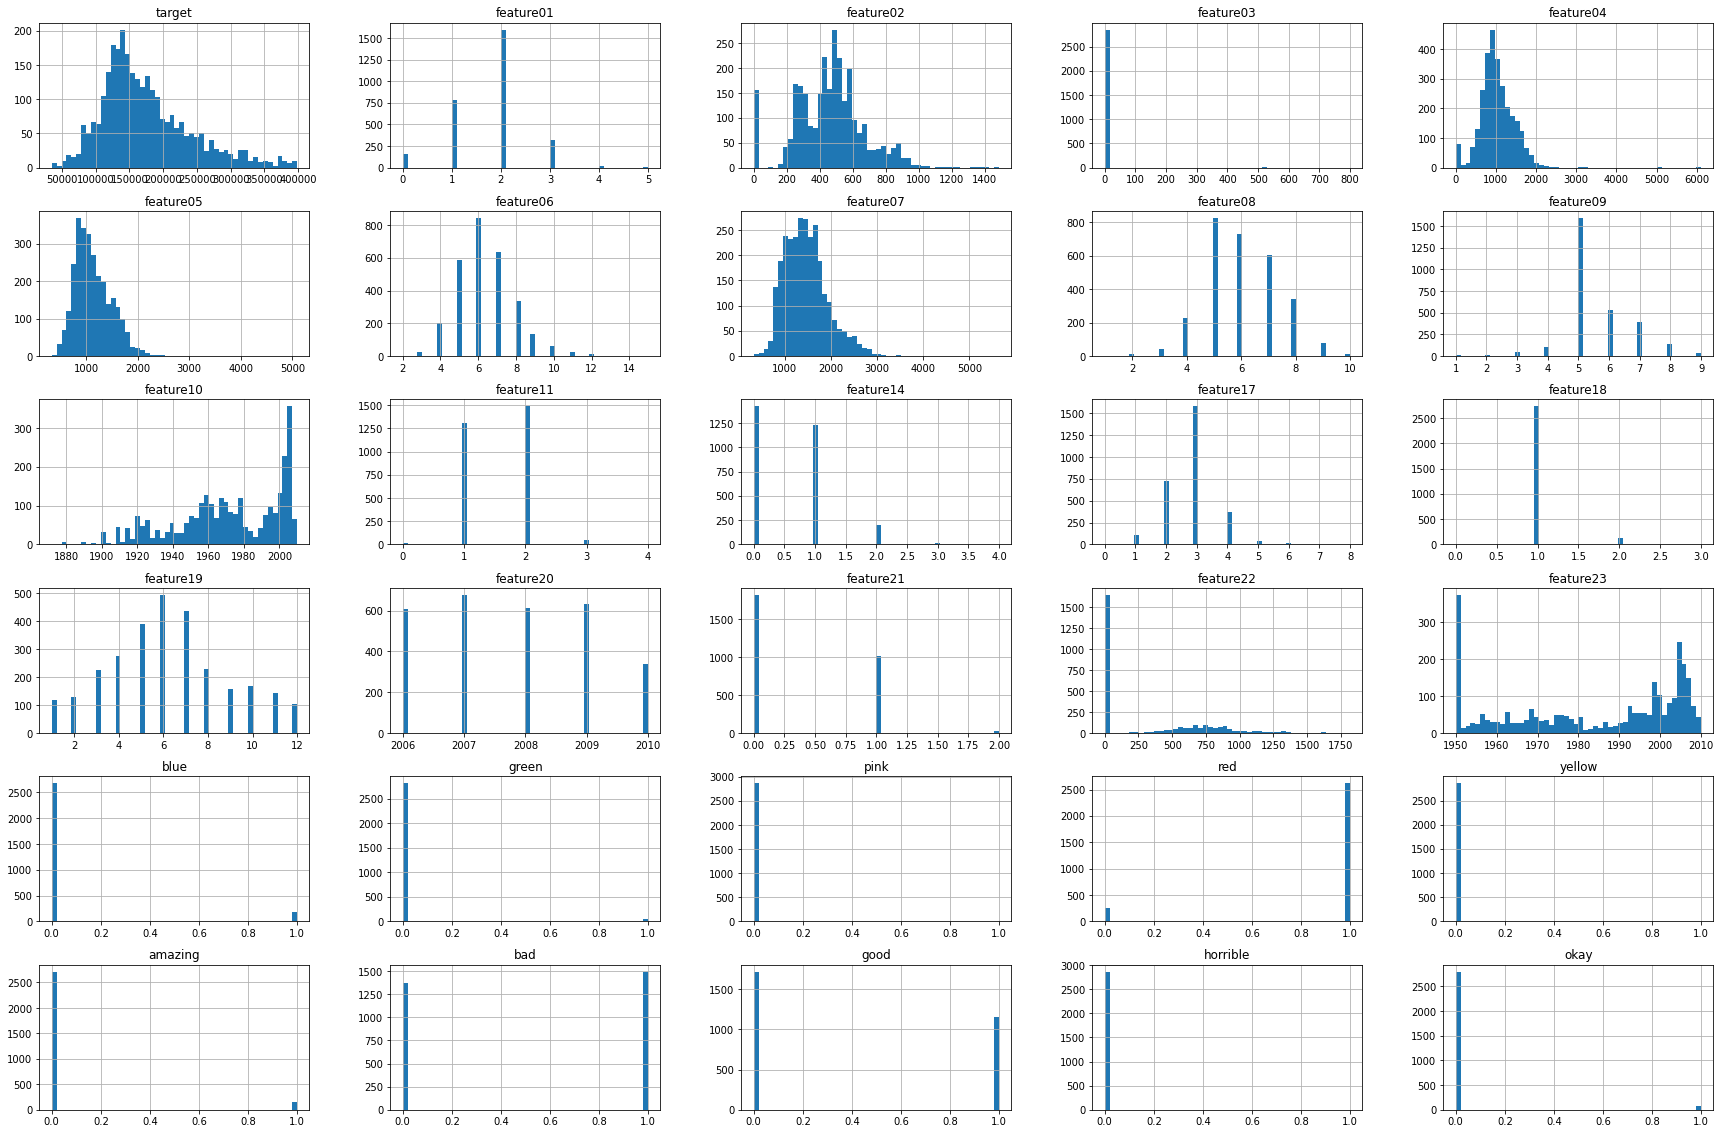

In [172]:
df_optimized.hist(bins=50, figsize=(30,20))
plt.show()

##### In the scatterplots and histograms above I draw the conclusion that in some features there are outliers and in other features the data is not usable for predictions because the data is distributed either 90% in one way or almost 50% between two values.
##### For example in 'feature03' 99% of the values are of value '0' and in feature 'bad' the data is almost exactly 50% distributed, this kind of data will not have any impact of the prediction, so I will drop features with this kind of distribution.
##### Below I will check the number of percent that differs between values in features that seem to have to be dropped.

In [173]:
print(df_optimized['feature03'].value_counts(normalize=True) * 100)
print(df_optimized['feature18'].value_counts(normalize=True) * 100)
print(df_optimized['blue'].value_counts(normalize=True) * 100)
print(df_optimized['green'].value_counts(normalize=True) * 100)
print(df_optimized['pink'].value_counts(normalize=True) * 100)
print(df_optimized['red'].value_counts(normalize=True) * 100)
print(df_optimized['yellow'].value_counts(normalize=True) * 100)
print(df_optimized['amazing'].value_counts(normalize=True) * 100)
print(df_optimized['bad'].value_counts(normalize=True) * 100)
print(df_optimized['good'].value_counts(normalize=True) * 100)
print(df_optimized['horrible'].value_counts(normalize=True) * 100)
print(df_optimized['okay'].value_counts(normalize=True) * 100)

0      99.615922
480     0.034916
576     0.034916
368     0.034916
444     0.034916
228     0.034916
561     0.034916
519     0.034916
648     0.034916
800     0.034916
512     0.034916
738     0.034916
Name: feature03, dtype: float64
1    95.321229
2     4.504190
0     0.104749
3     0.069832
Name: feature18, dtype: float64
0    93.47067
1     6.52933
Name: blue, dtype: float64
0    98.25419
1     1.74581
Name: green, dtype: float64
0    99.965084
1     0.034916
Name: pink, dtype: float64
1    91.410615
0     8.589385
Name: red, dtype: float64
0    99.72067
1     0.27933
Name: yellow, dtype: float64
0    94.657821
1     5.342179
Name: amazing, dtype: float64
1    52.129888
0    47.870112
Name: bad, dtype: float64
0    59.916201
1    40.083799
Name: good, dtype: float64
0    99.965084
1     0.034916
Name: horrible, dtype: float64
0    97.590782
1     2.409218
Name: okay, dtype: float64


##### I will drop the features that have either above 90% in each direction OR distributions with values between 60-40%.

In [174]:
df_optimized.drop(columns=['feature03', 'feature18', 'blue', 'green', 'red', 'pink', 'yellow', 'amazing', 'bad', 'good', 'horrible', 'okay'], inplace=True)

##### When looking at the scatterplot above, I can see that there seem to be some outliers in 'feature04', 'feature05' and 'feature07'. I will take a closer look att these with boxplots.

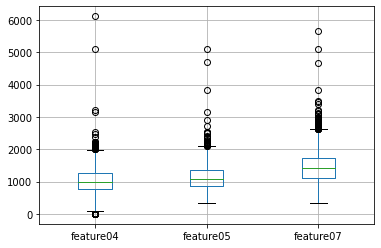

In [175]:
df_optimized.boxplot(column=['feature04', 'feature05', 'feature07']);

##### I will delete outliers above 3000 in all three of these features and then inspect the data again.

In [176]:
df_optimized.drop(df_optimized[(df_optimized['feature04'] > 2300)].index, inplace=True)
df_optimized.drop(df_optimized[(df_optimized['feature05'] > 2500)].index, inplace=True)
df_optimized.drop(df_optimized[(df_optimized['feature07'] > 3000)].index, inplace=True)

In [177]:
current_shape = df_optimized.shape
print(f'Original rows and columns: {original_shape}')
print(f'Current rows and columns: {current_shape}')

Original rows and columns: (2930, 26)
Current rows and columns: (2842, 18)


### These will be the features I will choose to keep:

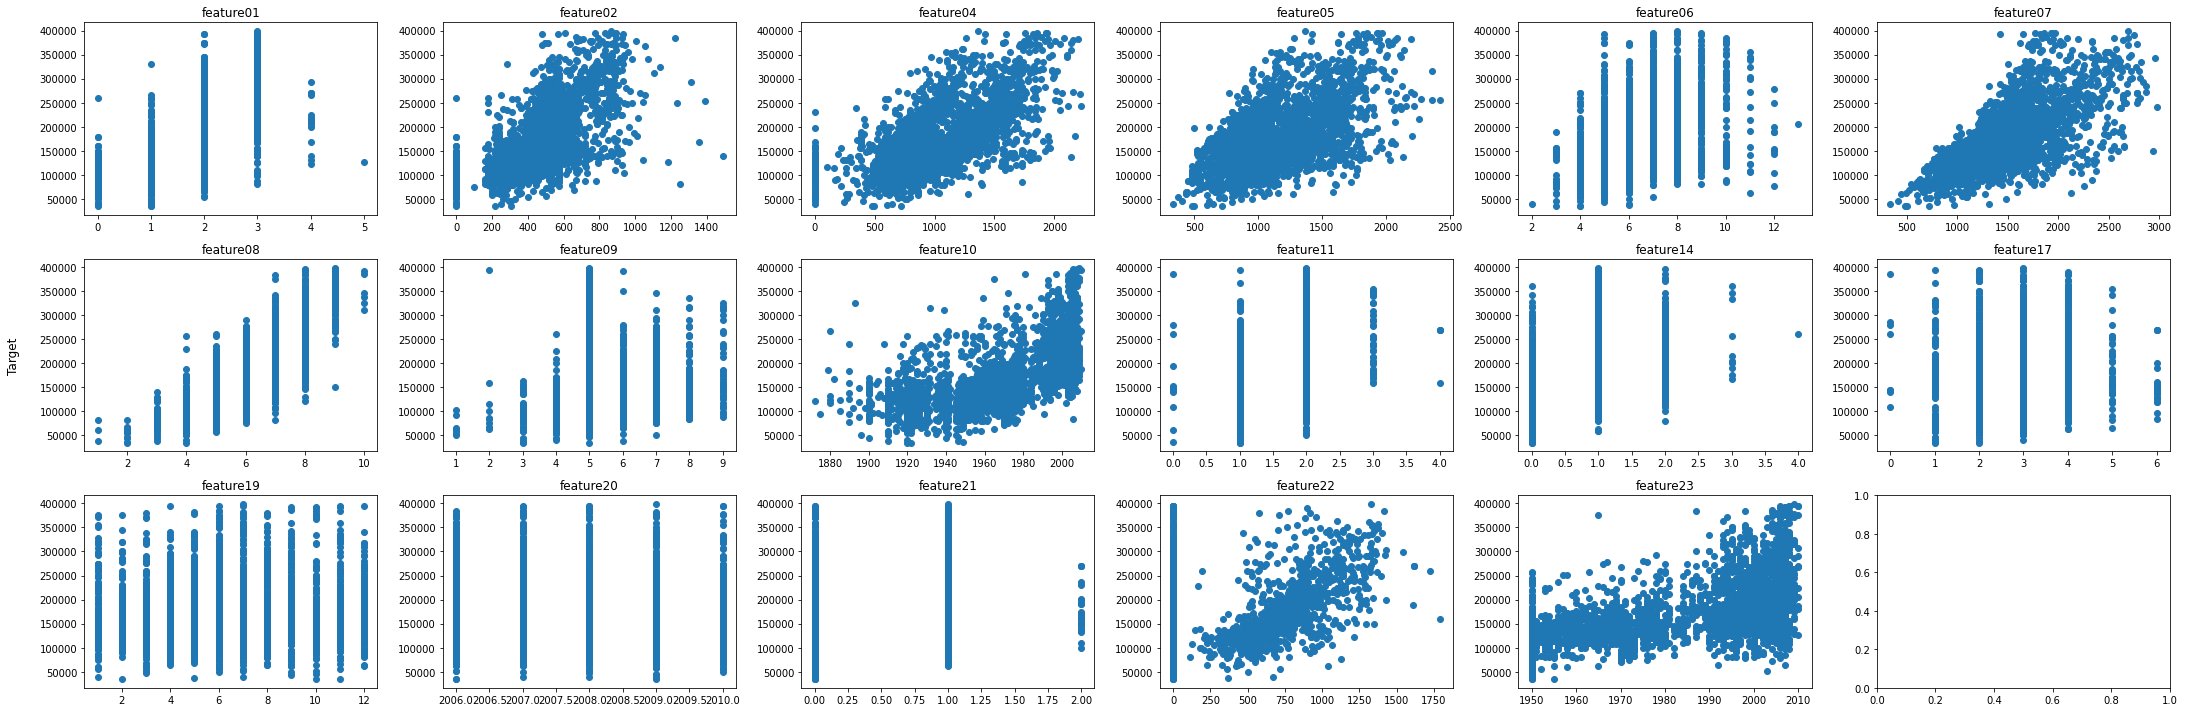

In [178]:
f, axarr = plt.subplots(3, 6, figsize=(30, 10))
target = df_optimized.target.values
axarr[0, 0].scatter(df_optimized.feature01.values, target)
axarr[0, 0].set_title('feature01')
axarr[0, 1].scatter(df_optimized.feature02.values, target)
axarr[0, 1].set_title('feature02')
axarr[0, 2].scatter(df_optimized.feature04.values, target)
axarr[0, 2].set_title('feature04')
axarr[0, 3].scatter(df_optimized.feature05.values, target)
axarr[0, 3].set_title('feature05')
axarr[0, 4].scatter(df_optimized.feature06.values, target)
axarr[0, 4].set_title('feature06')
axarr[0, 5].scatter(df_optimized.feature07.values, target)
axarr[0, 5].set_title('feature07')
axarr[1, 0].scatter(df_optimized.feature08.values, target)
axarr[1, 0].set_title('feature08')
axarr[1, 1].scatter(df_optimized.feature09.values, target)
axarr[1, 1].set_title('feature09')
axarr[1, 2].scatter(df_optimized.feature10.values, target)
axarr[1, 2].set_title('feature10')
axarr[1, 3].scatter(df_optimized.feature11.values, target)
axarr[1, 3].set_title('feature11')
axarr[1, 4].scatter(df_optimized.feature14.values, target)
axarr[1, 4].set_title('feature14')
axarr[1, 5].scatter(df_optimized.feature17.values, target)
axarr[1, 5].set_title('feature17')
axarr[2, 0].scatter(df_optimized.feature19.values, target)
axarr[2, 0].set_title('feature19')
axarr[2, 1].scatter(df_optimized.feature20.values, target)
axarr[2, 1].set_title('feature20')
axarr[2, 2].scatter(df_optimized.feature21.values, target)
axarr[2, 2].set_title('feature21')
axarr[2, 3].scatter(df_optimized.feature22.values, target)
axarr[2, 3].set_title('feature22')
axarr[2, 4].scatter(df_optimized.feature23.values, target)
axarr[2, 4].set_title('feature23')
f.text(-0.01, 0.5, 'Target', va='center', rotation='vertical', fontsize = 12)
plt.tight_layout()
plt.show()

### Re-modeling with optimized data

In [179]:
target_name = 'target'
robust_scaler = RobustScaler()
X = df_optimized.drop('target', axis=1)
X = robust_scaler.fit_transform(X)
y = df_optimized[target_name]

In [180]:
# Null model
y_pred_null = y.mean()
null_test_rmse_optimized = -1*mean_squared_error(y_pred=np.repeat(y_pred_null, y.size), y_true=y, squared=False)
null_test_mape_optimized = -1*mean_absolute_percentage_error(y_pred=np.repeat(y_pred_null, y.size), y_true=y)

In [181]:
# Learning models and creating valuation metrics.
rf = RandomForestRegressor(n_estimators=50, max_depth=15, random_state=2, n_jobs=-1)
rf_test_rmse_optimized = cross_validate(estimator=rf,X=X,y=y,
                                    scoring='neg_root_mean_squared_error', 
                                    cv=10, n_jobs=-1)['test_score']
rf_test_mape_optimized = cross_validate(estimator=rf,X=X,y=y,
                                    scoring='neg_mean_absolute_percentage_error', 
                                    cv=10, n_jobs=-1)['test_score']
rf_test_r2_optimized = cross_validate(estimator=rf,X=X,y=y,
                                    scoring='r2', 
                                    cv=10, n_jobs=-1)['test_score']


knn = KNeighborsRegressor(n_neighbors=20, weights='uniform', metric='euclidean', n_jobs=-1)
knn_test_rmse_optimized = cross_validate(estimator=knn,X=X,y=y,
                                    scoring='neg_root_mean_squared_error', 
                                    cv=10, n_jobs=-1)['test_score']
knn_test_mape_optimized = cross_validate(estimator=knn,X=X,y=y,
                                    scoring='neg_mean_absolute_percentage_error', 
                                    cv=10, n_jobs=-1)['test_score']
knn_test_r2_optimized = cross_validate(estimator=knn,X=X,y=y,
                                    scoring='r2', 
                                    cv=10, n_jobs=-1)['test_score']


boosting = AdaBoostRegressor(n_estimators=50, learning_rate=1.0, random_state=2)  
boosting_test_rmse_optimized = cross_validate(estimator=boosting,X=X,y=y,
                                    scoring='neg_root_mean_squared_error', 
                                    cv=10, n_jobs=-1)['test_score']
boosting_test_mape_optimized = cross_validate(estimator=boosting,X=X,y=y,
                                    scoring='neg_mean_absolute_percentage_error', 
                                    cv=10, n_jobs=-1)['test_score']
boosting_test_r2_optimized = cross_validate(estimator=boosting,X=X,y=y,
                                    scoring='r2', 
                                    cv=10, n_jobs=-1)['test_score']                                    

## Evaluating and comparing models with all features included to models which are optimized.

In [182]:
# Creating dataframes for  evaluation metrics.
r2_models_optimized =  pd.DataFrame({'KNN Optimized features':knn_test_r2_optimized,
                           'RandomForest Optimized features': rf_test_r2_optimized,
                           'Boosting Optimized features':boosting_test_r2_optimized,})
result_r2_models = pd.concat([r2_models_AllFeatures, r2_models_optimized], axis=1)


rmse_models_optimized = -1*pd.DataFrame({'KNN Optimized features':knn_test_rmse_optimized,
                           'RandomForest Optimized features': rf_test_rmse_optimized,
                           'Boosting Optimized features':boosting_test_rmse_optimized,
                           'NULL Optimized features':null_test_rmse_optimized})
result_rmse_models = pd.concat([rmse_models_AllFeatures, rmse_models_optimized], axis=1)


mape_models_optimized = -1*pd.DataFrame({'KNN Optimized features':knn_test_mape_optimized,
                           'RandomForest Optimized features': rf_test_mape_optimized,
                           'Boosting Optimized features':boosting_test_mape_optimized,
                           'NULL Optimized features':null_test_mape_optimized})
result_mape_models = pd.concat([mape_models_AllFeatures, mape_models_optimized], axis=1)    

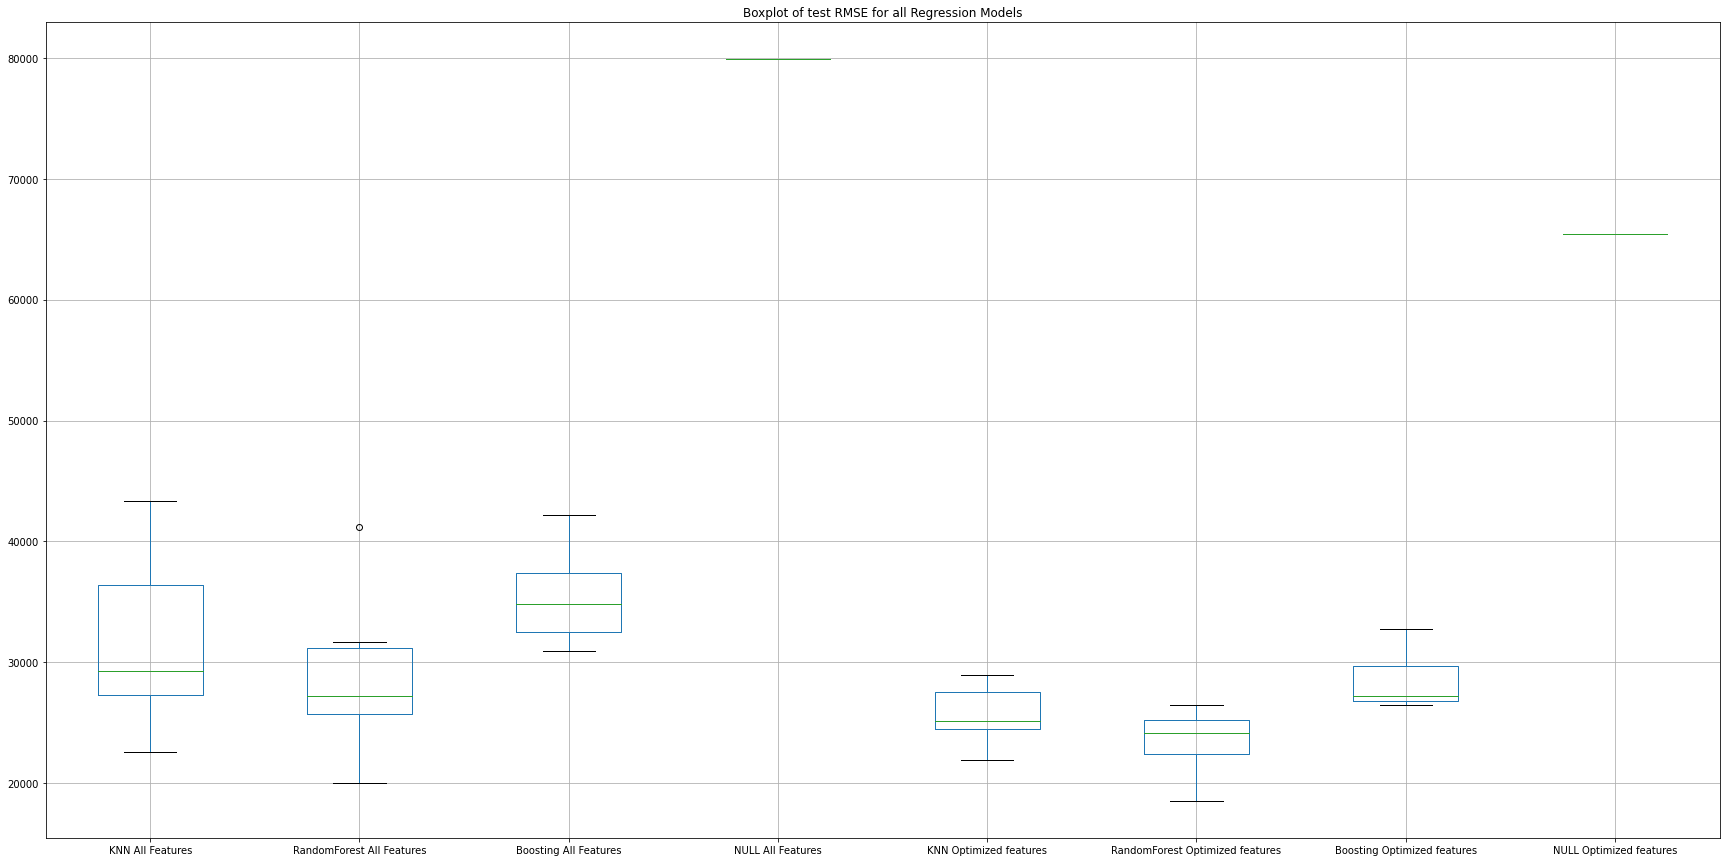

In [183]:
fig, ax = plt.subplots(figsize=(30,15))
result_rmse_models.boxplot(ax=ax)
ax.set_title('Boxplot of test RMSE for all Regression Models');

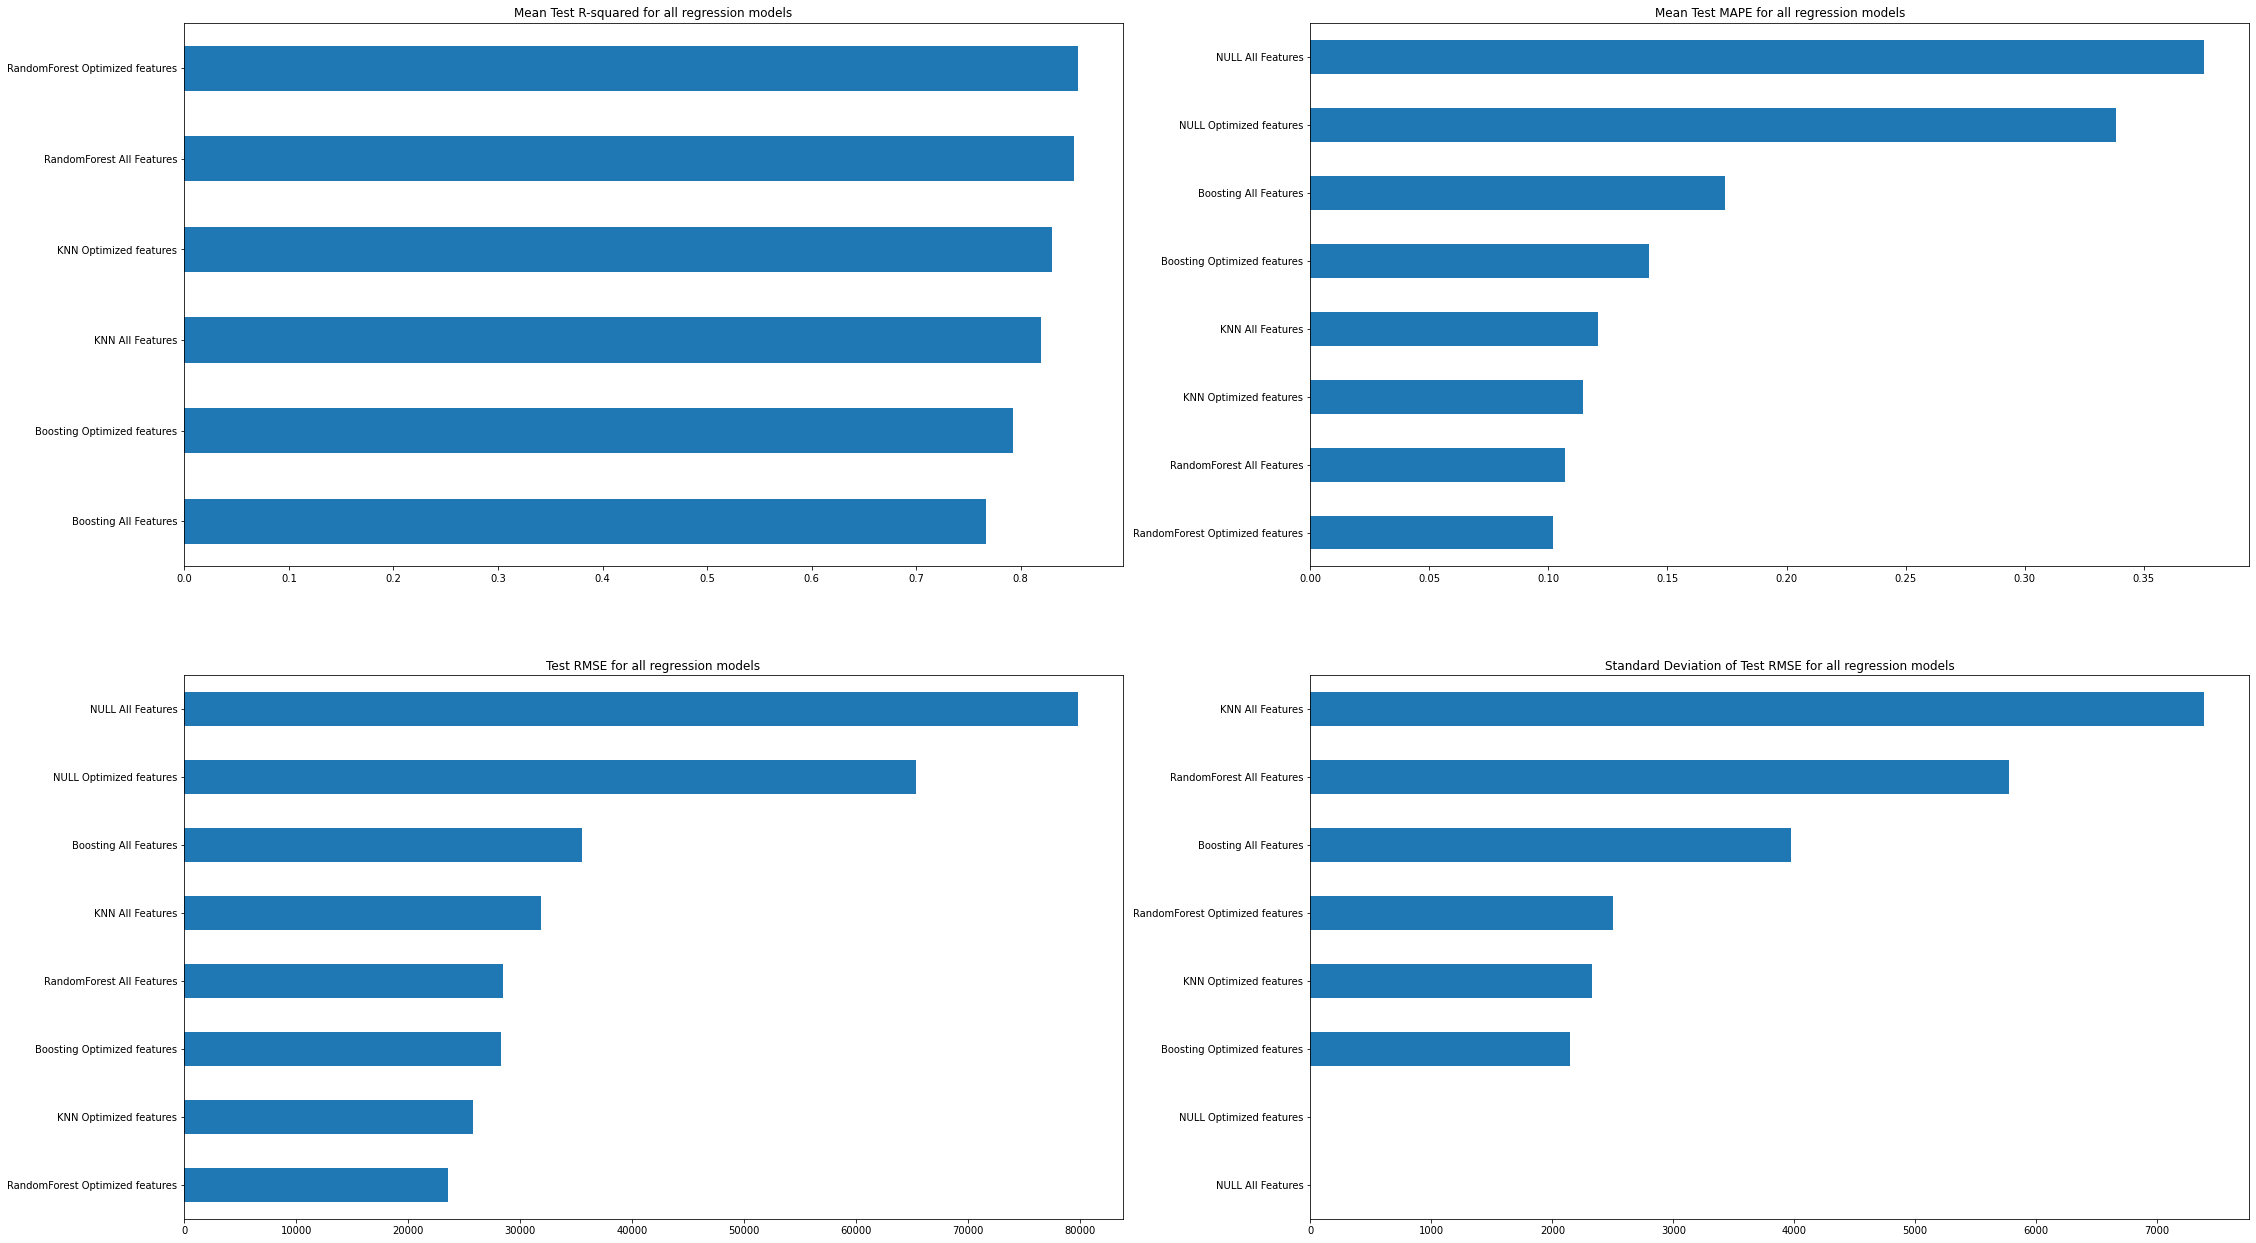

In [184]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(37,22))

result_r2_models.mean().sort_values().plot(kind='barh', ax=ax1)
ax1.set_title('Mean Test R-squared for all regression models')
result_mape_models.mean().sort_values().plot(kind='barh', ax=ax2)
ax2.set_title('Mean Test MAPE for all regression models')
result_rmse_models.mean().sort_values().plot(kind='barh', ax=ax3)
ax3.set_title('Test RMSE for all regression models')
result_rmse_models.std().sort_values().plot(kind='barh', ax=ax4)
ax4.set_title('Standard Deviation of Test RMSE for all regression models');

### Feature Importance

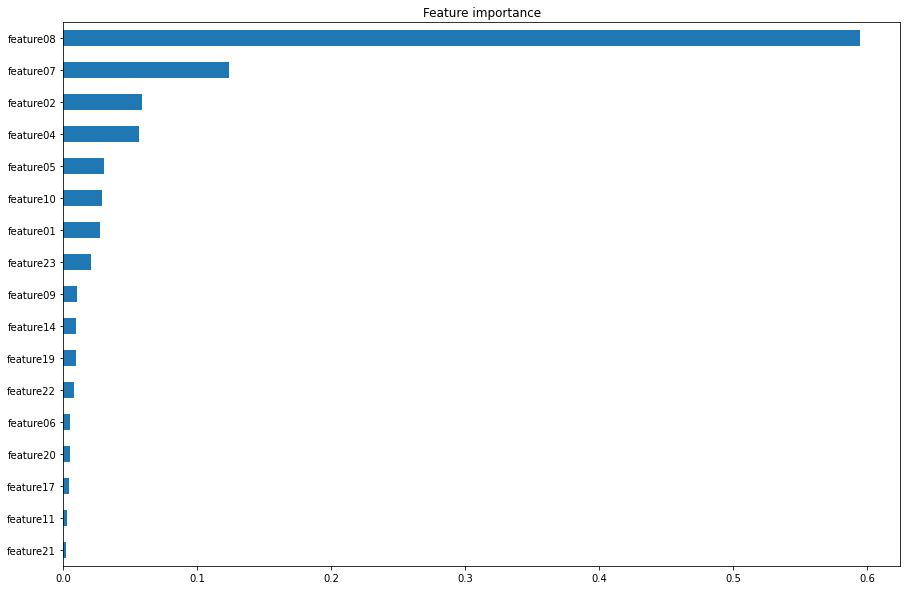

In [185]:
rf_model = RandomForestRegressor(n_estimators=50, max_depth=15, random_state=2, n_jobs=-1)
rf_model.fit(X, y)
feature_importance = pd.Series(rf_model.feature_importances_, index=df_optimized.drop('target', axis=1).columns)
fig, ax = plt.subplots(figsize=(15,10))
feature_importance.sort_values().plot(kind='barh', ax=ax)
ax.set_title('Feature importance');

## Conclusion

##### All models have scored better after the optimization of feature selection and removal of outliers. The best model is the RandomForestRegressor, it scored best both before and after the optimization, it scores the best result in 3 out of 4 metrics. It has the highest accuracy with a mean r-squared well above 0.8 and it has a MAPE of around 0.10, which indicates that there is a low percent of errors. The most important feature have clearly been feature08.

##### I have not used regualarization to reduce the error, so I dont know if overfitting is an issue here. There is probably a chance to optimize the models a bit more if I use for example Exhaustive Grid Search to tune the hyperparameters.
 